In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import end2end, end2end_crps

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('kin8nm')

In [3]:
end2end_model = end2end_crps.train_model(x_train, y_train, n_epoch = 500, hidden_layers = [100, 100, 100], learning_rate = 0.001, exp_decay = .995, calibration_threshold = .03)

initial loss:  0.20368312299251556
251 0.6676947325987638 tensor(-2.8103, grad_fn=<MeanBackward0>) tensor(0.0825, grad_fn=<MeanBackward0>)
252 0.1722225477022305 tensor(-3.1884, grad_fn=<MeanBackward0>) tensor(0.0644, grad_fn=<MeanBackward0>)
253 0.24189744692287024 tensor(-3.2889, grad_fn=<MeanBackward0>) tensor(0.0656, grad_fn=<MeanBackward0>)
254 0.03944834721848963 tensor(-3.4033, grad_fn=<MeanBackward0>) tensor(0.0589, grad_fn=<MeanBackward0>)
255 0.0823392905133029 tensor(-3.4372, grad_fn=<MeanBackward0>) tensor(0.0596, grad_fn=<MeanBackward0>)
257 0.048833619994625106 tensor(-3.4725, grad_fn=<MeanBackward0>) tensor(0.0583, grad_fn=<MeanBackward0>)
259 0.03966361193227628 tensor(-3.4900, grad_fn=<MeanBackward0>) tensor(0.0578, grad_fn=<MeanBackward0>)
261 0.036633458747648485 tensor(-3.5026, grad_fn=<MeanBackward0>) tensor(0.0574, grad_fn=<MeanBackward0>)
263 0.036941359849502836 tensor(-3.5125, grad_fn=<MeanBackward0>) tensor(0.0572, grad_fn=<MeanBackward0>)
265 0.04172276269819

367 0.05078540714861599 tensor(-3.7525, grad_fn=<MeanBackward0>) tensor(0.0513, grad_fn=<MeanBackward0>)
369 0.043024294544477315 tensor(-3.7638, grad_fn=<MeanBackward0>) tensor(0.0510, grad_fn=<MeanBackward0>)
371 0.0374343187315238 tensor(-3.7721, grad_fn=<MeanBackward0>) tensor(0.0507, grad_fn=<MeanBackward0>)
373 0.03416191883902179 tensor(-3.7785, grad_fn=<MeanBackward0>) tensor(0.0505, grad_fn=<MeanBackward0>)
375 0.032533109379199156 tensor(-3.7835, grad_fn=<MeanBackward0>) tensor(0.0504, grad_fn=<MeanBackward0>)
377 0.0322453372749261 tensor(-3.7874, grad_fn=<MeanBackward0>) tensor(0.0503, grad_fn=<MeanBackward0>)
379 0.03314813222252084 tensor(-3.7904, grad_fn=<MeanBackward0>) tensor(0.0503, grad_fn=<MeanBackward0>)
381 0.03473813490997046 tensor(-3.7924, grad_fn=<MeanBackward0>) tensor(0.0502, grad_fn=<MeanBackward0>)
383 0.037145202902445586 tensor(-3.7935, grad_fn=<MeanBackward0>) tensor(0.0502, grad_fn=<MeanBackward0>)
385 0.040782612201021244 tensor(-3.7935, grad_fn=<Mean

End2end test MAPE:  0.13910913
End2end test RMSE:  0.09349433
End2end test NLLK:  -3.532824
End2end test CRPS:  tensor(0.0526)


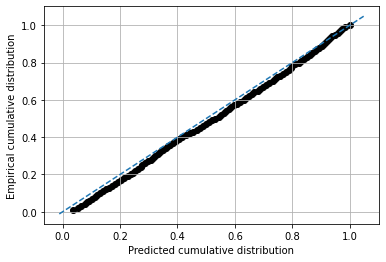

End2end test calibration error when step size is 0.001:  0.6877781460101118
End2end test calibration error when step size is 0.01:  0.06873390938437965
End2end test calibration error when step size is 0.1:  0.0067255208771282065


In [4]:
mean_pred, var_pred = end2end_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [5]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.75it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.72it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.072
  RMSE          0.093
  MDAE          0.059
  MARPD         12.364
  R2            0.872
  Correlation   0.934
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.018
  Mean-absolute Calibration Error       0.014
  Miscalibration Area                   0.014
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.039
     Group Size: 0.56 -- Calibration Error: 0.020
     Group Size: 1.00 -- Calibration Error: 0.014
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.045
     Group Size: 0.56 -- Calibration Error: 0.024
     Group Size: 1.00 -- Calibration Error: 0.018
===============

Lims is None. Setting lims now:
min_max_true: (0.06322076, 1.4585207)
min_max_pred: (0.22368634, 1.4927974)
lims: (0.06322076, 1.4927974)
lims_ext: (-0.07973690181970597, 1.6357550382614137)


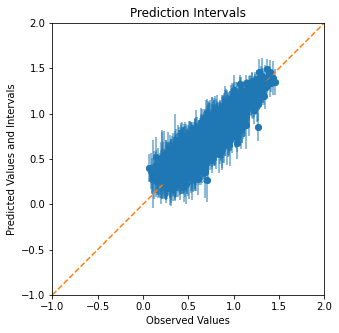

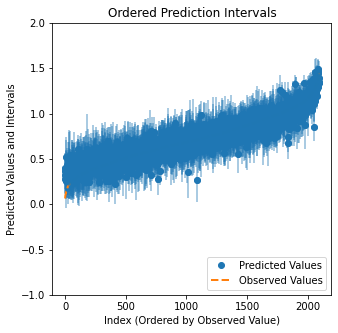

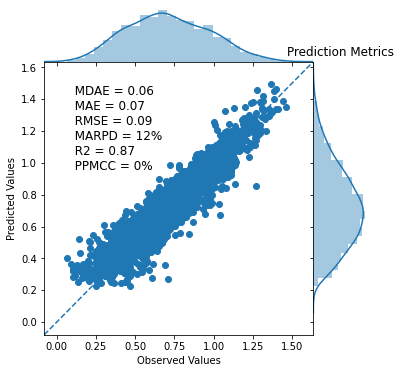

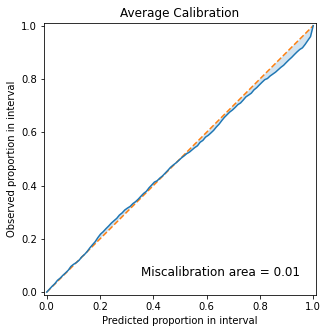

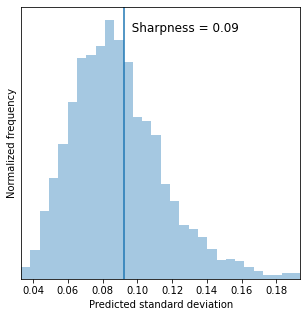

In [6]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [3]:
nllk_model = end2end_crps.train_model_nllk(x_train, y_train, n_epoch = 500, hidden_layers = [100, 100, 100], learning_rate = 0.001, exp_decay = .995, calibration_threshold = .03)

initial loss:  0.44835734367370605
final loss:  -4.044358730316162


End2end test MAPE:  0.13141657
End2end test RMSE:  0.091167346
End2end test NLLK:  -3.7665534
End2end test CRPS:  tensor(0.0503)


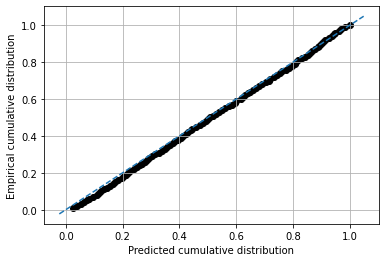

End2end test calibration error when step size is 0.001:  0.24263251976938435
End2end test calibration error when step size is 0.01:  0.024480621798785455
End2end test calibration error when step size is 0.1:  0.002056911698576744


In [4]:
mean_pred, var_pred = nllk_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [5]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.44it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.69it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.070
  RMSE          0.091
  MDAE          0.056
  MARPD         11.939
  R2            0.878
  Correlation   0.937
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.015
  Mean-absolute Calibration Error       0.011
  Miscalibration Area                   0.011
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.038
     Group Size: 0.56 -- Calibration Error: 0.019
     Group Size: 1.00 -- Calibration Error: 0.011
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.047
     Group Size: 0.56 -- Calibration Error: 0.022
     Group Size: 1.00 -- Calibration Error: 0.015
===============

Lims is None. Setting lims now:
min_max_true: (0.06322076, 1.4585207)
min_max_pred: (0.2402609, 1.500396)
lims: (0.06322076, 1.500396)
lims_ext: (-0.08049676567316055, 1.644113540649414)


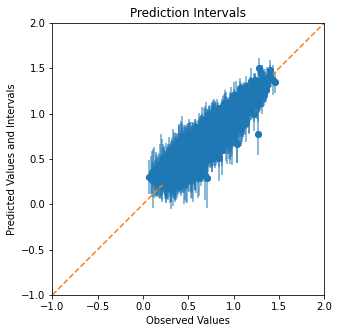

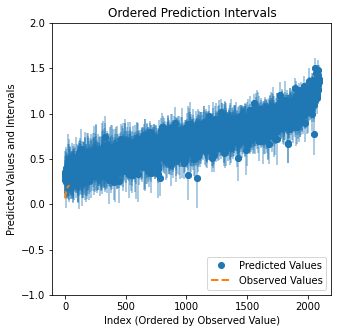

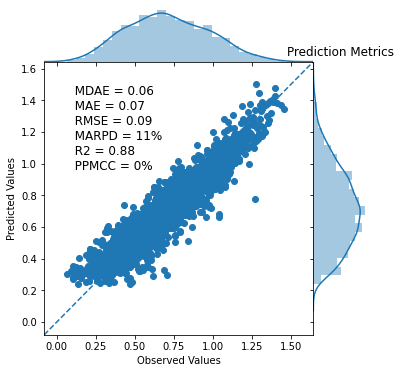

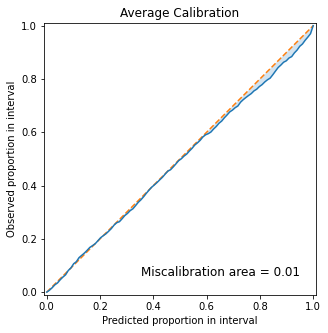

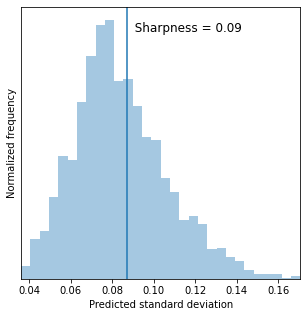

In [6]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [7]:
crps_model = end2end_crps.train_model_crps(x_train, y_train, n_epoch = 500, hidden_layers = [100, 100, 100], learning_rate = 0.001, exp_decay = .995, calibration_threshold = .03)

initial loss:  0.4711475372314453
final loss:  0.04134068265557289


End2end test MAPE:  0.119222194
End2end test RMSE:  0.085193366
End2end test NLLK:  -3.6786342
End2end test CRPS:  tensor(0.0475)


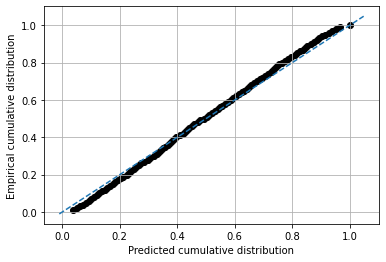

End2end test calibration error when step size is 0.001:  0.5652102153702171
End2end test calibration error when step size is 0.01:  0.05640448544761257
End2end test calibration error when step size is 0.1:  0.0050811339931049445


In [9]:
mean_pred, var_pred = crps_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [10]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.69it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.61it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.065
  RMSE          0.085
  MDAE          0.052
  MARPD         11.080
  R2            0.894
  Correlation   0.945
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.046
  Mean-absolute Calibration Error       0.040
  Miscalibration Area                   0.040
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.070
     Group Size: 0.56 -- Calibration Error: 0.048
     Group Size: 1.00 -- Calibration Error: 0.040
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.073
     Group Size: 0.56 -- Calibration Error: 0.055
     Group Size: 1.00 -- Calibration Error: 0.046
===============

Lims is None. Setting lims now:
min_max_true: (0.06322076, 1.4585207)
min_max_pred: (0.12981376, 1.4399682)
lims: (0.06322076, 1.4585207)
lims_ext: (-0.07630922943353655, 1.5980506420135498)


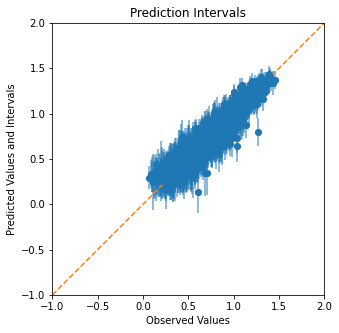

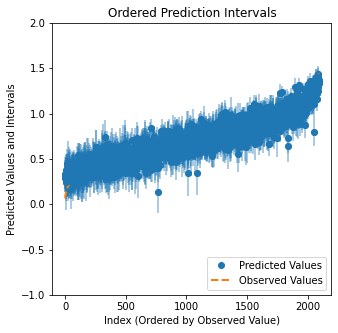

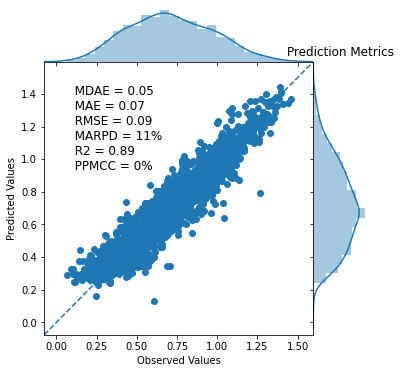

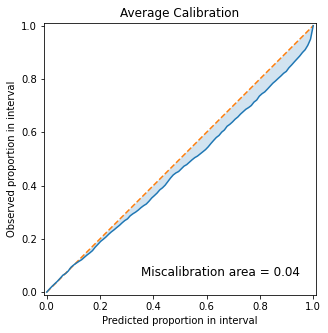

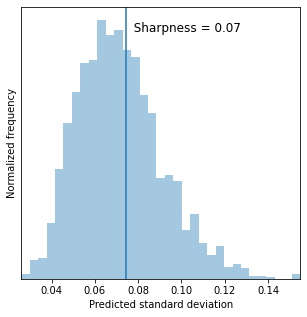

In [11]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))